In [1]:
import tensorflow as tf 
import numpy as np
from Bio import SeqIO
import json
from sklearn.model_selection import train_test_split
import feature as fe 
import copy 
from tensorflow.keras import *
import seaborn as sns 
import matplotlib
import matplotlib.pyplot as plt 
import pandas as pd 

from sklearn import metrics
matplotlib.rcParams['font.family']='Heiti TC'#修改了全局变量

%matplotlib inline 
%config InlineBackend.figure_format = 'jpg' #以矢量图的形式显示图片，这样比较清晰
plt.style.use({'figure.figsize':(20,16)})



def drawMetrics(y_true,y_pred,modelName = 'unknown'):
    out = []
    for threshold in [i/100 for i in range(100)]:
        index= metricsIndex(y_true,y_pred,threshold)
        out.append(index)
    out = np.array(out)
    modelMetrics = pd.DataFrame(out,columns=['MCC','ACC','Sensitivity','Specificity'])
    modelMetrics.plot()
    plt.legend(loc='upper left',fontsize=15)
    plt.title(modelName+'模型的MCC，准确性，敏感性和特异性随阈值的变化曲线图',fontsize=15)
    #plt.savefig(modelName+'模型的MCC，准确性，敏感性和特异性随阈值的变化曲线图'+'.jpg',dpi=500)

def drawlossinTwoSet(data,modelname='未知'):
    y1 = data.history['loss']
    y2 = data.history['val_loss']
    x = range(len(y1))
    #modelname= 'TotalFeaturesmodel'
    filename = modelname+'loss'

    sns.lineplot(x =x  ,y=y1)
    plt.xticks(ticks=x,labels=['epoch'+ str(i+1)for i in x],fontsize=1)
    #for i,j in zip(x,y1):
        #plt.text(i,j+0.005*j,'loss={:.2}'.format(j),fontsize=12)
    #plt.hlines(max(y1),x[-20],x[-1])
    plt.text(x[-9],max(y1),'train_loss= {:.5}'.format(max(y1)),fontsize=14)

    sns.lineplot(x=x,y=y2,color='b')

    plt.text(x[-9],np.median(y2),'val_loss= {:.5}'.format(np.median(y2)),fontsize=14)

    #for i,j in zip(x,y2):
        #plt.text(i,j-0.01*j,'loss={:.2}'.format(j),color = 'b',fontsize=12)
    plt.title('牛奶过敏BCEs'+modelname+'模型训练loss结果图',fontsize=30)    

    plt.legend(['训练集','测试集'],loc='upper left',fontsize=30)
    #plt.savefig(filename+'.jpg',dpi=500)

def drawACCinTwoSet(data,modelname='未知'):
    y1 = data.history['acc']
    y2 = data.history['val_acc']
    x = range(len(y1))
    #modelname= 'TotalFeaturesmodel'
    filename = modelname+'ACC'

    sns.lineplot(x =x  ,y=y1)
    plt.xticks(ticks=x,labels=['epoch'+ str(i+1)for i in x],fontsize=1)
    #for i,j in zip(x,y1):
        #plt.text(i,j+0.005*j,'acc={:.2}'.format(j),fontsize=12)
    #plt.hlines(max(y1),x[-20],x[-1])
    plt.text(x[-9],max(y1),'train_acc= {:.5}'.format(max(y1)),fontsize=14)

    sns.lineplot(x=x,y=y2,color='b')

    plt.text(x[-9],np.median(y2),'val_acc= {:.5}'.format(np.median(y2)),fontsize=14)

    #for i,j in zip(x,y2):
        #plt.text(i,j-0.01*j,'acc={:.2}'.format(j),color = 'b',fontsize=12)
    plt.title('牛奶过敏BCEs'+modelname+'模型训练acc结果图',fontsize=30)    

    plt.legend(['训练集','测试集'],loc='upper left',fontsize=30)
    #plt.savefig(filename+'.jpg',dpi=500)
    
def applynumpyArray1D(arr,func):
    """
    
    """
    array = copy.deepcopy(arr)  
    for i in range(array.shape[0]):
        array[i] = func(array[i])
    return array

def normize(array):
    """
    input: np.array shape = (n,) 一维向量 
    output: 对 输入的数据进行归一化，即 (a_i - a.mean())/a.std  若全为0，则返回原array。
    
    """
    temp = copy.deepcopy(array)
    if (array == 0).all():#应当添加()
        normizedarray = temp
    else:
        normizedarray = (temp-temp.mean())/temp.std()
    return normizedarray
def twoDArraynormize(twoDArray):
    """
    input: np.array, shape = (n,m)  n为样本个数，m为特征个数，  对每一个样本的同一个特征进行归一化处理即 (m_i - m's mean)/m'std
    output: np.array, shape = (n,m) n为样本个数，m为特征个数。 归一化后的结果 

    """
    temp = copy.deepcopy(twoDArray)
    for i in range(temp.shape[1]):
        array = temp[:,i]
        temp[:,i] = normize(array)
    return temp    
    

#词向量化
def amino_acids2numvector(sequenceArray,toknizer):
    """
    input:
        sequence:(n,) np.array类型，多肽序列
        toknizer: 氨基酸toknizer。    
    output:（n,200) 数字化后的多肽序列
    """
    sequenceArray = applynumpyArray1D(sequenceArray,lambda x: ' '.join(x))
    sequenceArray = toknizer.texts_to_sequences(sequenceArray)
    #选取最常长度为20
    sequenceArray = tf.keras.preprocessing.sequence.pad_sequences(sequenceArray,truncating='post',padding='post',maxlen=20)
    return sequenceArray


#AAC Matrix
def aminoacids2AACMatrix(array):
    """
    
    """
    tmp = copy.deepcopy(array)
    tmp = applynumpyArray1D(tmp,fe.CalculateAAComposition)
    AACMatrix = applynumpyArray1D(tmp,lambda x: [i for i in x.values()])#输出是（n,)的shape
    #转化为np.array，shape为（n,20）
    AACMatrix = np.array(AACMatrix.tolist())
    return AACMatrix

#DPC Matrix
#DPC Matrix
def aminoacids2DPCMatrix(array):
    """
    
    """
    tmp = copy.deepcopy(array)
    tmp = applynumpyArray1D(tmp,fe.CalculateDipeptideComposition)
    DPCMatrix = applynumpyArray1D(tmp,lambda x: [i for i in x.values()])#输出是（n,)的shape
    #转化为np.array，shape为（n,20）
    DPCMatrix = np.array(DPCMatrix.tolist())
    return DPCMatrix

#CTD Matrix
def aminoacids2CTDMatrix(array):
    """
    
    """
    tmp = copy.deepcopy(array)
    tmp = applynumpyArray1D(tmp,fe.CalculateCTD)
    CTDMatrix = applynumpyArray1D(tmp,lambda x: [i for i in x.values()])#输出是（n,)的shape
    #转化为np.array，shape为（n,20）
    CTDMatrix = np.array(CTDMatrix.tolist())
    return CTDMatrix
#AAI Matrix
def aminoacids2AAIMatrix(array):
    """
    
    """
    tmp = copy.deepcopy(array)
    tmp = applynumpyArray1D(tmp,fe.CalculateAAIndex)
    AAIMatrix = applynumpyArray1D(tmp,lambda x: [i for i in x.values()])#输出是（n,)的shape
    #转化为np.array，shape为（n,20）
    AAIMatrix = np.array(AAIMatrix.tolist())
    return AAIMatrix

#新的embeding，自定义
def embedingProteinSequence(sequence,properities,maxlen=20):
    """
    input:
            sequence: protein 序列，str类型
            properities: 一个字典格式，包含多个氨基酸分类的化学性质的key和对应的各个氨基酸的数字值。有n个key。
            maxlen: 多肽序列保留的长度
    output:
            对氨基酸序列进行编码替换，最终生成一个n,maxlen 的numpy数组
    
    """
    proteinSequence = sequence
    out =[[properity[amino] for amino in proteinSequence] for name,properity in properities.items()]
    out = np.array(out)
    
    out = tf.keras.preprocessing.sequence.pad_sequences(out,truncating='post',padding='post',value=0,maxlen=20,dtype='float32')
    return out
def vectoriseProteinSeq(seqArray,properities,maxlen=20):
    """
    input:
            seqArray: protein 序列的集合，list类型，包含u条序列
            properities: 一个字典格式，包含多个氨基酸分类的化学性质的key和对应的各个氨基酸的数字值。有n个key。
            maxlen: 多肽序列保留的长度
    output:
            对氨基酸序列进行编码替换并stack，最终生成一个u,n,maxlen 的numpy数组
    
    """
    temp = [embedingProteinSequence(seq,properities,maxlen) for seq in seqArray]
    out = np.stack(temp)
    return out

#生成数据集
def generateFeaturesData(sequenceData,normize=False,properities=fe.AAIdex_8features,maxlen=20):
    """
    input:
        properities: 被用于embeding中，一个字典格式，包含多个氨基酸分类的化学性质的key和对应的各个氨基酸的数字值。有n个key。
        maxlen: 被用于embeding中，多肽序列保留的长度
        sequence:(n,) np.array类型，包含n条多肽序列的数组
    output:[AAC,DPC,CTD,AAI,SeqVec]的一个列表
    """
    data = copy.deepcopy(sequenceData)
    AAC = aminoacids2AACMatrix(data)
    if normize:
        AAC = twoDArraynormize(AAC)
    
    DPC = aminoacids2DPCMatrix(data)
    if normize:
        DPC = twoDArraynormize(DPC)
    
    CTD = aminoacids2CTDMatrix(data)
    if normize:
        CTD = twoDArraynormize(CTD)
    
    AAI = aminoacids2AAIMatrix(data)
    #if normize:
    AAI = twoDArraynormize(AAI)
    
    SeqVec = amino_acids2numvector(data,toknizer)
    #默认使用fe中的AAIdex的8类特征
    embeding = vectoriseProteinSeq(data,properities,maxlen)
    return [AAC,DPC,CTD,AAI,SeqVec,embeding]



def metricsEvaluate(y_true,y_pred,p_threshold):
    """
    input:
        y_pred:模型的预测概率，是一个np.array的数组，函数会对预测概率根据制定的预测阈值指定分类
        y_true:数据的真实分类，是一个np.array的数组
        p_threshold:指定分类阈值，大于这个值会分类为1，小于会分类为0
    output:[Sensitivity,Specificity,MCC]
    
    """
    y_pred = copy.deepcopy(y_pred)
    y_pred[y_pred>=p_threshold]=1
    y_pred[y_pred<=p_threshold]=0
    confusion_matrix = metrics.confusion_matrix(y_true=y_true,y_pred = y_pred)
    tn, fp, fn, tp = confusion_matrix.ravel()
    Sensitivity = tp/(tp+fn)
    Specificity = tn/(tn+fp)
    MCC = metrics.matthews_corrcoef(y_true,y_pred)
    ACC = metrics.accuracy_score(y_true,y_pred)
    print('模型的ACC为:{:.2f},\n模型的敏感性为:{:.2f},\n特异性为:{:.2f},\nMCC系数为:{:.2f}'.format(ACC,Sensitivity,Specificity,MCC))
    return [ACC,Sensitivity,Specificity,MCC]

def metricsIndex(y_true,y_pred,p_threshold):
    """
    input:
        y_pred:模型的预测概率，是一个np.array的数组，函数会对预测概率根据制定的预测阈值指定分类
        y_true:数据的真实分类，是一个np.array的数组
        p_threshold:指定分类阈值，大于这个值会分类为1，小于会分类为0
    output:[Sensitivity,Specificity,MCC]
    
    """
    y_pred = copy.deepcopy(y_pred)
    y_pred[y_pred>=p_threshold]=1
    y_pred[y_pred<=p_threshold]=0
    confusion_matrix = metrics.confusion_matrix(y_true=y_true,y_pred = y_pred)
    tn, fp, fn, tp = confusion_matrix.ravel()
    Sensitivity = tp/(tp+fn)
    Specificity = tn/(tn+fp)
    MCC = metrics.matthews_corrcoef(y_true,y_pred)
    ACC = metrics.accuracy_score(y_true,y_pred)
    return [MCC,ACC,Sensitivity,Specificity]

def PCA(X,k):
    """
    input：
        X：原数据，np.array类型，shape=(n,m),n为样本数目，m为维度
        k：降低到多少维
    output:
        Y：降维后的数据，shape=(n,k)
    """
    number = X.shape[0]
    dimension = X.shape[1]
    X = X - X.mean(axis=0)
    C = np.dot(X.T,X)/number
    
    eig_val,eig_vec = np.linalg.eig(C)
    
    eig_List = [(np.abs(eig_val[i]),eig_vec[:,i]) for i in range(dimension)]
    try:
        eig_List.sort(reverse=True)
        P = np.array([each_List[1] for each_List in eig_List[:k]])
        Y = np.dot(X,P.T)
        return Y 
    except:
        print('出现特征值相同的情况啦，该代码无法继续运行下去，换用其他方式进行PCA处理！')
        return eig_List

## 数据读取

In [2]:
 #读取 词分类器
with open('tfsModel/RNNamino_acids_toknizer.json','r') as f:
    toknizer =tf.keras.preprocessing.text.tokenizer_from_json(json.load(f))

# milkAllergyBCEs = pd.read_csv('milk allergy linear BCEs bovine dataset.csv')['Description'].values
# milkAllergynonBCEs = pd.read_csv('milk allergy linear non-BCEs experiece confirmed.csv')['Description'].values
# milkAllergyBCEsFeatures = generateFeaturesData(milkAllergyBCEs)
# milkAllergynonBCEsFeatures = generateFeaturesData(milkAllergynonBCEs)
# milkAllergyTargets = np.concatenate([np.ones((milkAllergyBCEsFeatures[0].shape[0],)),np.zeros((milkAllergynonBCEsFeatures[0].shape[0],))])


In [3]:
# AACMatrix = np.concatenate([milkAllergyBCEsFeatures[0],milkAllergynonBCEsFeatures[0]])
# AACTargets = milkAllergyTargets
                           
# DPCMatrix = np.concatenate([milkAllergyBCEsFeatures[1],milkAllergynonBCEsFeatures[1]])
# DPCTargets = milkAllergyTargets
                           
# CTDMatrix = np.concatenate([milkAllergyBCEsFeatures[2],milkAllergynonBCEsFeatures[2]])
# CTDTargets = milkAllergyTargets
                           
# AAIMatrix = np.concatenate([milkAllergyBCEsFeatures[3],milkAllergynonBCEsFeatures[3]])
# AAITargets = milkAllergyTargets

# RNNMatrix = np.concatenate([milkAllergyBCEsFeatures[4],milkAllergynonBCEsFeatures[4]])
# RNNTargets = milkAllergyTargets
                           
# embedingProteinMatrix = np.concatenate([milkAllergyBCEsFeatures[5],milkAllergynonBCEsFeatures[5]])
# embedingProteinTargets = milkAllergyTargets

In [4]:
# #数据集切割
# AAC_Xtrain,AAC_Xtest,AAC_Ytrain,AAC_Ytest = train_test_split(AACMatrix,AACTargets,test_size=0.3) 
# DPC_Xtrain,DPC_Xtest,DPC_Ytrain,DPC_Ytest = train_test_split(DPCMatrix,DPCTargets,test_size=0.3) 
# CTD_Xtrain,CTD_Xtest,CTD_Ytrain,CTD_Ytest = train_test_split(CTDMatrix,CTDTargets,test_size=0.3) 
# AAI_Xtrain,AAI_Xtest,AAI_Ytrain,AAI_Ytest = train_test_split(AAIMatrix,AAITargets,test_size=0.3) 
# RNN_Xtrain,RNN_Xtest,RNN_Ytrain,RNN_Ytest = train_test_split(RNNMatrix,RNNTargets,test_size=0.3)
# embedingProtein_Xtrain,embedingProtein_Xtest,embedingProtein_Ytrain,embedingProtein_Ytest = train_test_split(embedingProteinMatrix,embedingProteinTargets,test_size=0.3)



In [5]:
# #保存分割好的数据集

# import os 
# filename = 'tfsDataSet/MilkDate/'
# if os.path.exists(filename):
#     pass 
# else:
#     os.makedirs(filename)

# np.save(filename+'AAC_Xtrain.npy',AAC_Xtrain)
# np.save(filename+'AAC_Ytrain.npy',AAC_Ytrain)
# np.save(filename+'AAC_Xtest.npy',AAC_Xtest)
# np.save(filename+'AAC_Ytest.npy',AAC_Ytest)

# np.save(filename+'DPC_Xtrain.npy',DPC_Xtrain)
# np.save(filename+'DPC_Ytrain.npy',DPC_Ytrain)
# np.save(filename+'DPC_Xtest.npy',DPC_Xtest)
# np.save(filename+'DPC_Ytest.npy',DPC_Ytest)

# np.save(filename+'CTD_Xtrain.npy',CTD_Xtrain)
# np.save(filename+'CTD_Ytrain.npy',CTD_Ytrain)
# np.save(filename+'CTD_Xtest.npy',CTD_Xtest)
# np.save(filename+'CTD_Ytest.npy',CTD_Ytest)

# np.save(filename+'AAI_Xtrain.npy',AAI_Xtrain)
# np.save(filename+'AAI_Ytrain.npy',AAI_Ytrain)
# np.save(filename+'AAI_Xtest.npy',AAI_Xtest)
# np.save(filename+'AAI_Ytest.npy',AAI_Ytest)

# np.save(filename+'RNN_Xtrain.npy',RNN_Xtrain)
# np.save(filename+'RNN_Ytrain.npy',RNN_Ytrain)
# np.save(filename+'RNN_Xtest.npy',RNN_Xtest)
# np.save(filename+'RNN_Ytest.npy',RNN_Ytest)

# np.save(filename+'embedingProtein_Xtrain.npy',embedingProtein_Xtrain)
# np.save(filename+'embedingProtein_Ytrain.npy',embedingProtein_Ytrain)
# np.save(filename+'embedingProtein_Xtest.npy',embedingProtein_Xtest)
# np.save(filename+'embedingProtein_Ytest.npy',embedingProtein_Ytest)


In [6]:
## 读入分割好的数据集
filename = 'tfsDataSet/MilkDate/'

AAC_Xtrain,AAC_Ytrain,AAC_Xtest,AAC_Ytest = np.load(filename+'AAC_Xtrain.npy'),np.load(filename+'AAC_Ytrain.npy'),np.load(filename+'AAC_Xtest.npy'),np.load(filename+'AAC_Ytest.npy')
DPC_Xtrain,DPC_Ytrain,DPC_Xtest,DPC_Ytest = np.load(filename+'DPC_Xtrain.npy'),np.load(filename+'DPC_Ytrain.npy'),np.load(filename+'DPC_Xtest.npy'),np.load(filename+'DPC_Ytest.npy')
CTD_Xtrain,CTD_Ytrain,CTD_Xtest,CTD_Ytest = np.load(filename+'CTD_Xtrain.npy'),np.load(filename+'CTD_Ytrain.npy'),np.load(filename+'CTD_Xtest.npy'),np.load(filename+'CTD_Ytest.npy')
AAI_Xtrain,AAI_Ytrain,AAI_Xtest,AAI_Ytest = np.load(filename+'AAI_Xtrain.npy'),np.load(filename+'AAI_Ytrain.npy'),np.load(filename+'AAI_Xtest.npy'),np.load(filename+'AAI_Ytest.npy')
RNN_Xtrain,RNN_Ytrain,RNN_Xtest,RNN_Ytest = np.load(filename+'RNN_Xtrain.npy'),np.load(filename+'RNN_Ytrain.npy'),np.load(filename+'RNN_Xtest.npy'),np.load(filename+'RNN_Ytest.npy')
embedingProtein_Xtrain,embedingProtein_Ytrain,embedingProtein_Xtest,embedingProtein_Ytest = np.load(filename+'embedingProtein_Xtrain.npy'),np.load(filename+'embedingProtein_Ytrain.npy'),np.load(filename+'embedingProtein_Xtest.npy'),np.load(filename+'embedingProtein_Ytest.npy')





In [7]:
AAC_Xtrain.shape,DPC_Xtrain.shape,CTD_Xtrain.shape,AAI_Xtrain.shape,RNN_Xtrain.shape,embedingProtein_Xtrain.shape 

((324, 20), (324, 400), (324, 147), (324, 140), (324, 20), (324, 7, 20))

In [8]:
AAC_Xtest.shape,DPC_Xtest.shape,CTD_Xtest.shape,AAI_Xtest.shape,RNN_Xtest.shape,embedingProtein_Xtest.shape 

((140, 20), (140, 400), (140, 147), (140, 140), (140, 20), (140, 7, 20))

In [9]:
#转化为td.Dataset类型
#训练集数据
AACtrainDataset = tf.data.Dataset.from_tensor_slices((AAC_Xtrain,AAC_Ytrain)).shuffle(100).batch(32)
DPCtrainDataset = tf.data.Dataset.from_tensor_slices((DPC_Xtrain,DPC_Ytrain)).shuffle(100).batch(32)
CTDtrainDataset = tf.data.Dataset.from_tensor_slices((CTD_Xtrain,CTD_Ytrain)).shuffle(100).batch(32)
AAItrainDataset = tf.data.Dataset.from_tensor_slices((AAI_Xtrain,AAI_Ytrain)).shuffle(100).batch(32)
RNNtrainDataset = tf.data.Dataset.from_tensor_slices((RNN_Xtrain,RNN_Ytrain)).shuffle(100).batch(32)
embedingProteintrainDataset = tf.data.Dataset.from_tensor_slices((embedingProtein_Xtrain,embedingProtein_Ytrain)).shuffle(100).batch(32)




#测试集数据
AACtestDataset = tf.data.Dataset.from_tensor_slices((AAC_Xtest,AAC_Ytest)).shuffle(100).batch(32)
DPCtestDataset = tf.data.Dataset.from_tensor_slices((DPC_Xtest,DPC_Ytest)).shuffle(100).batch(32)
CTDtestDataset = tf.data.Dataset.from_tensor_slices((CTD_Xtest,CTD_Ytest)).shuffle(100).batch(32)
AAItestDataset = tf.data.Dataset.from_tensor_slices((AAI_Xtest,AAI_Ytest)).shuffle(100).batch(64)
RNNtestDataset = tf.data.Dataset.from_tensor_slices((RNN_Xtest,RNN_Ytest)).shuffle(100).batch(64)
embedingProteintestDataset = tf.data.Dataset.from_tensor_slices((embedingProtein_Xtest,embedingProtein_Ytest)).shuffle(100).batch(64)




## 基于embeding的方式构建的模型

In [10]:
lr = 0.0002
embedingProteinModel = tf.keras.Sequential()
#embedingProteinModel.add(tf.keras.layers.Convolution1D(64,8,strides=4,padding='same',activation='relu'))
#embedingProteinModel.add(tf.keras.layers.MaxPool1D(2))
#embedingProteinModel.add(tf.keras.layers.Flatten())
embedingProteinModel.add(tf.keras.layers.LSTM(64))
#embedingProteinModel.add(tf.keras.layers.Dense(64,activation='relu'))
embedingProteinModel.add(tf.keras.layers.Dense(64,kernel_regularizer= regularizers.l2(100),activation='relu'))
embedingProteinModel.add(tf.keras.layers.Dropout(0.2))
embedingProteinModel.add(tf.keras.layers.Dense(1,activation='sigmoid'))
embedingProteinModel.compile(optimizer=tf.keras.optimizers.Adam(lr),
                            loss = tf.keras.losses.binary_crossentropy,
                            metrics=['acc','AUC'])



In [11]:
out = embedingProteinModel.fit(embedingProteintrainDataset,epochs=150,validation_data=embedingProteintestDataset)



Epoch 1/150
11/11 [==============================] - 3s 118ms/step - loss: 6433.3963 - acc: 0.5354 - auc: 0.5351 - val_loss: 6286.2266 - val_acc: 0.5214 - val_auc: 0.7208
Epoch 2/150
11/11 [==============================] - 0s 6ms/step - loss: 6240.5458 - acc: 0.5446 - auc: 0.7079 - val_loss: 6096.9170 - val_acc: 0.5643 - val_auc: 0.7652
Epoch 3/150
11/11 [==============================] - 0s 6ms/step - loss: 6052.4105 - acc: 0.5999 - auc: 0.7436 - val_loss: 5912.5972 - val_acc: 0.5857 - val_auc: 0.7942
Epoch 4/150
11/11 [==============================] - 0s 7ms/step - loss: 5869.3123 - acc: 0.6279 - auc: 0.7731 - val_loss: 5733.4058 - val_acc: 0.6357 - val_auc: 0.7998
Epoch 5/150
11/11 [==============================] - 0s 7ms/step - loss: 5691.3555 - acc: 0.6456 - auc: 0.8039 - val_loss: 5559.3188 - val_acc: 0.7357 - val_auc: 0.8096
Epoch 6/150
11/11 [==============================] - 0s 7ms/step - loss: 5518.4491 - acc: 0.7446 - auc: 0.8588 - val_loss: 5390.2300 - val_acc: 0.7429 - 

11/11 [==============================] - 0s 6ms/step - loss: 1338.6700 - acc: 0.8715 - auc: 0.9498 - val_loss: 1302.8744 - val_acc: 0.7286 - val_auc: 0.8039
Epoch 50/150
11/11 [==============================] - 0s 6ms/step - loss: 1291.6284 - acc: 0.8724 - auc: 0.9487 - val_loss: 1256.9561 - val_acc: 0.7357 - val_auc: 0.8020
Epoch 51/150
11/11 [==============================] - 0s 6ms/step - loss: 1246.0580 - acc: 0.8792 - auc: 0.9491 - val_loss: 1212.4662 - val_acc: 0.7214 - val_auc: 0.7935
Epoch 52/150
11/11 [==============================] - 0s 6ms/step - loss: 1201.9195 - acc: 0.8870 - auc: 0.9336 - val_loss: 1169.3630 - val_acc: 0.7286 - val_auc: 0.7961
Epoch 53/150
11/11 [==============================] - 0s 6ms/step - loss: 1159.1027 - acc: 0.9046 - auc: 0.9521 - val_loss: 1127.6124 - val_acc: 0.7286 - val_auc: 0.7956
Epoch 54/150
11/11 [==============================] - 0s 6ms/step - loss: 1117.6729 - acc: 0.9043 - auc: 0.9576 - val_loss: 1087.1750 - val_acc: 0.7143 - val_auc: 

Epoch 98/150
11/11 [==============================] - 0s 6ms/step - loss: 187.1570 - acc: 0.9850 - auc: 0.9975 - val_loss: 181.1106 - val_acc: 0.6857 - val_auc: 0.7908
Epoch 99/150
11/11 [==============================] - 0s 6ms/step - loss: 178.8543 - acc: 0.9900 - auc: 0.9987 - val_loss: 173.0555 - val_acc: 0.6857 - val_auc: 0.7918
Epoch 100/150
11/11 [==============================] - 0s 6ms/step - loss: 170.8660 - acc: 0.9944 - auc: 0.9984 - val_loss: 165.3216 - val_acc: 0.6857 - val_auc: 0.7880
Epoch 101/150
11/11 [==============================] - 0s 6ms/step - loss: 163.2050 - acc: 0.9927 - auc: 0.9962 - val_loss: 157.8959 - val_acc: 0.6786 - val_auc: 0.7869
Epoch 102/150
11/11 [==============================] - 0s 6ms/step - loss: 155.8530 - acc: 0.9951 - auc: 0.9985 - val_loss: 150.7649 - val_acc: 0.6786 - val_auc: 0.7881
Epoch 103/150
11/11 [==============================] - 0s 6ms/step - loss: 148.7915 - acc: 0.9937 - auc: 0.9984 - val_loss: 143.9223 - val_acc: 0.6786 - val_

Epoch 147/150
11/11 [==============================] - 0s 6ms/step - loss: 15.0810 - acc: 0.9973 - auc: 0.9999 - val_loss: 14.6669 - val_acc: 0.6786 - val_auc: 0.7848
Epoch 148/150
11/11 [==============================] - 0s 6ms/step - loss: 14.2429 - acc: 0.9958 - auc: 1.0000 - val_loss: 13.8569 - val_acc: 0.6714 - val_auc: 0.7783
Epoch 149/150
11/11 [==============================] - 0s 6ms/step - loss: 13.4324 - acc: 0.9966 - auc: 0.9991 - val_loss: 13.0900 - val_acc: 0.6714 - val_auc: 0.7812
Epoch 150/150
11/11 [==============================] - 0s 6ms/step - loss: 12.6873 - acc: 0.9966 - auc: 0.9994 - val_loss: 12.3642 - val_acc: 0.6714 - val_auc: 0.7765


模型的ACC为:0.67,
模型的敏感性为:0.74,
特异性为:0.60,
MCC系数为:0.35


/Users/xutingfeng/opt/anaconda3/envs/Bio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Text(0.5, 1.0, 'embedingProteinModel模型的MCC，准确性，敏感性和特异性随阈值的变化曲线图')

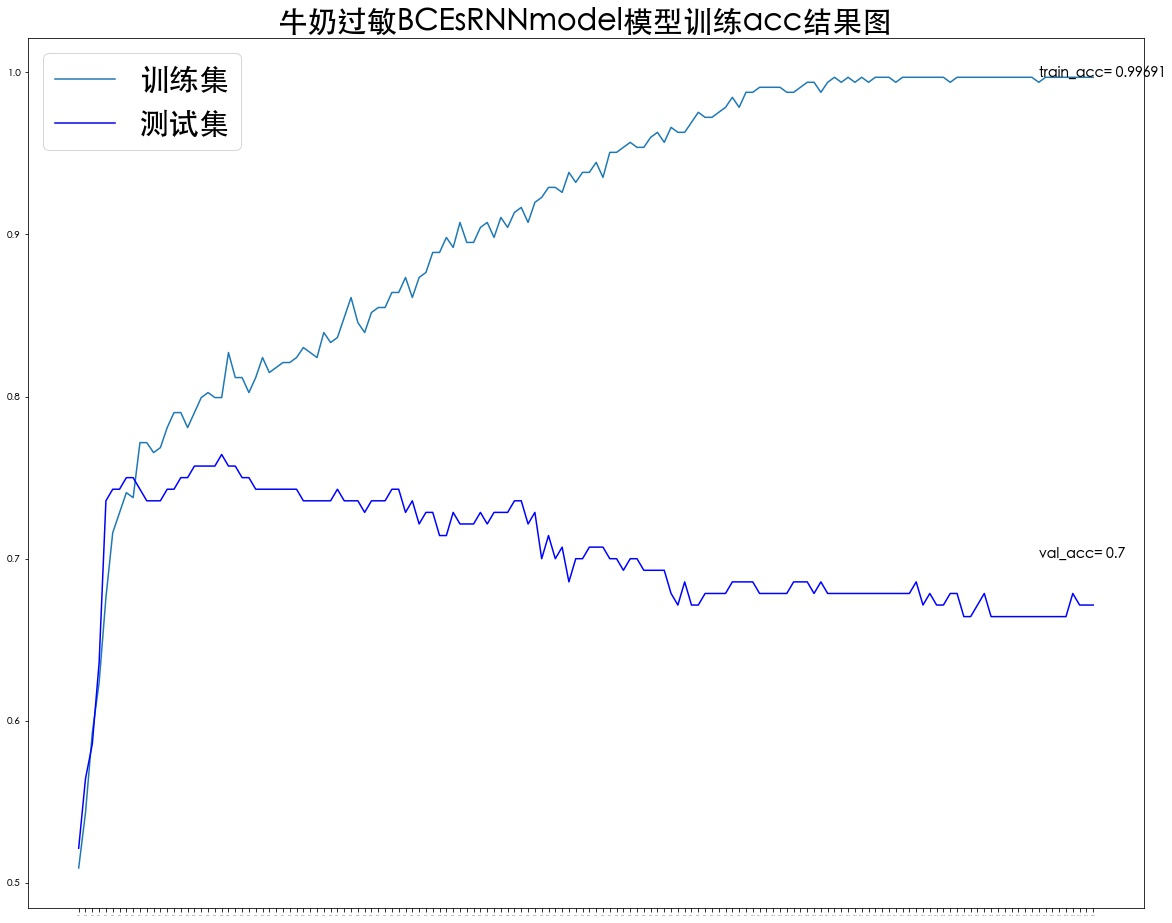

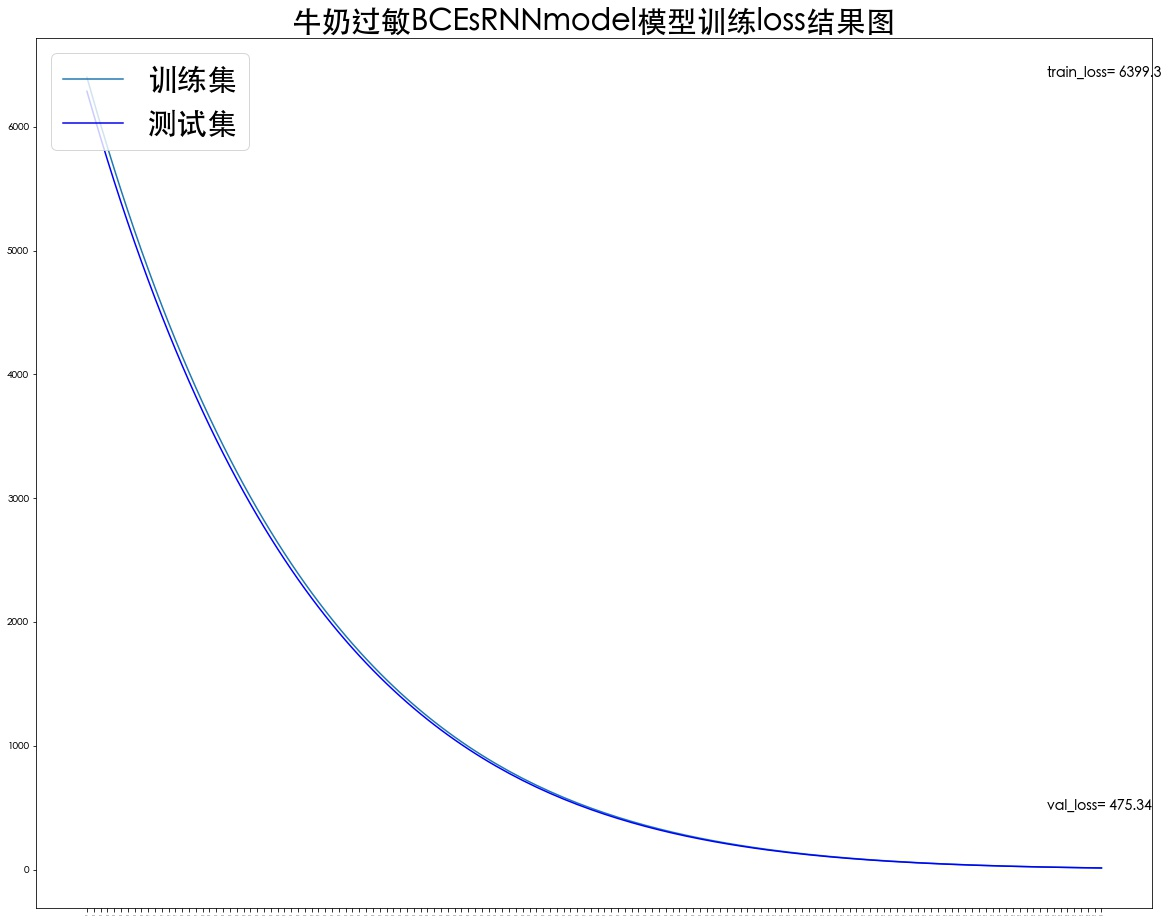

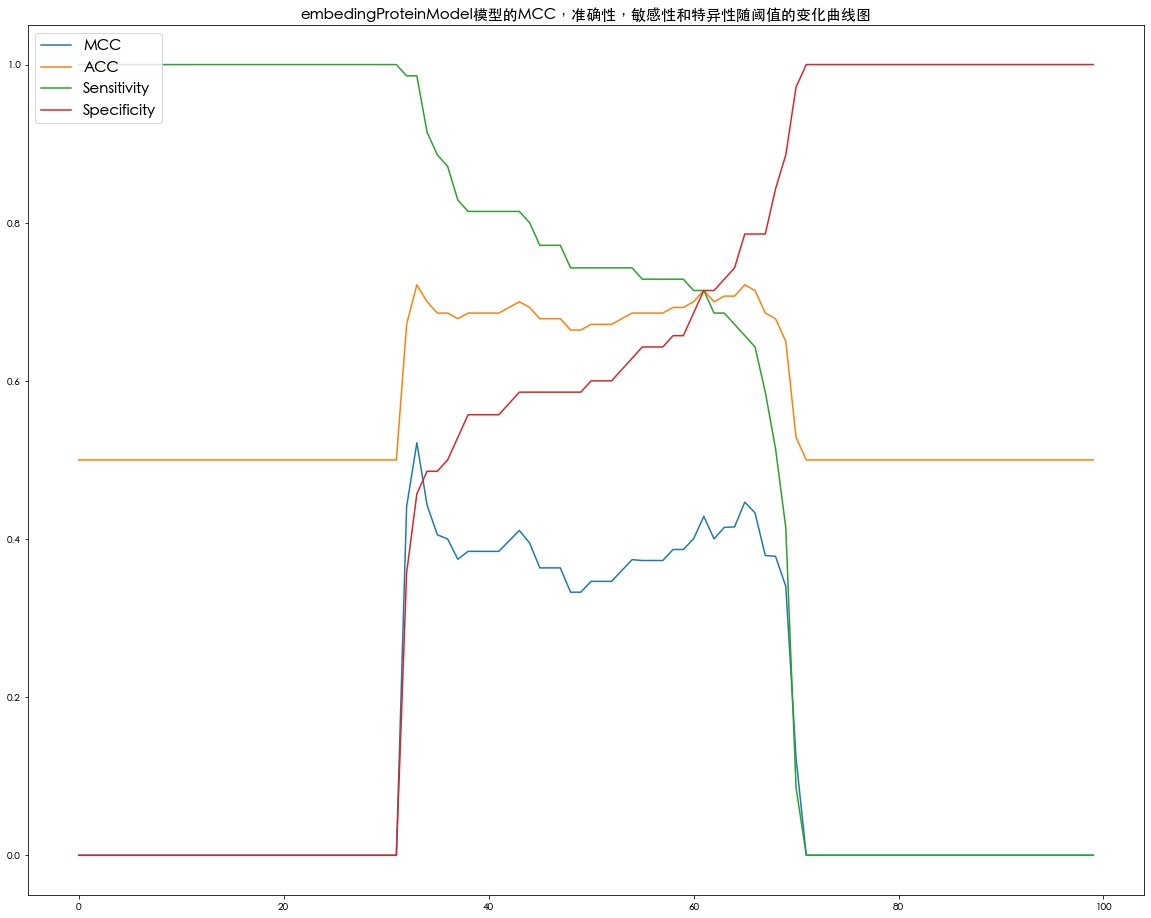

In [12]:
metricsEvaluate(embedingProtein_Ytest,embedingProteinModel.predict(embedingProtein_Xtest),0.5)
drawACCinTwoSet(out,'RNNmodel')
plt.figure()
drawlossinTwoSet(out,'RNNmodel')

y_true =embedingProtein_Ytest
y_pred = embedingProteinModel.predict(embedingProtein_Xtest)
modelName='embedingProteinModel'
#def drawMetrics(y_true,y_pred,modelName = 'unknown'):
out = []
for threshold in [i/100 for i in range(100)]:
    index= metricsIndex(y_true,y_pred,threshold)
    out.append(index)
out = np.array(out)
modelMetrics = pd.DataFrame(out,columns=['MCC','ACC','Sensitivity','Specificity'])
modelMetrics.plot()
plt.legend(loc='upper left',fontsize=15)
plt.title(modelName+'模型的MCC，准确性，敏感性和特异性随阈值的变化曲线图',fontsize=15)
#plt.savefig(modelName+'模型的MCC，准确性，敏感性和特异性随阈值的变化曲线图'+'.jpg',dpi=500)





In [13]:
import feature as fe 
import IEDBdo as IEDB
import pandas as pd 
import numpy as np 

totaldf = pd.read_csv('IEDB数据集/人食物过敏.csv',header=1,index_col=0)
BCEsdf = pd.read_csv('IEDB数据集/人食物过敏相关BCEs.csv',header=1,index_col=0)
BCEs,nonBCEs = IEDB.eatIEDBData(BCEsdf,totaldf,'人食物过敏数据集')

IEDBID为753500，的多肽序列包含有未知氨基酸X


In [18]:
data = generateFeaturesData(np.concatenate([BCEs,nonBCEs]))

In [23]:
a=np.ones(BCEs.shape[0],)
b=np.zeros(nonBCEs.shape[0],)
y = np.concatenate([a,b])

In [ ]:
ModelRNN = tf.keras.models.load_model('tfsModel/RNNModel.h5')

In [39]:
ModelAAC = tf.keras.models.load_model('tfsModel/AACModel.h5')
ModelDPC = tf.keras.models.load_model('tfsModel/DPCModel.h5')
ModelCTD = tf.keras.models.load_model('tfsModel/CTDModel.h5')
ModelAAI = tf.keras.models.load_model('tfsModel/AAIModel.h5')
ModelRNN = tf.keras.models.load_model('tfsModel/RNNModel.h5')

In [40]:
i = y.shape[0]
ModelAAC.evaluate(data[0][:i],y[:i])
ModelDPC.evaluate(data[1][:i],y[:i])
ModelCTD.evaluate(data[2][:i],y[:i])
ModelAAI.evaluate(data[3][:i],y[:i])
ModelRNN.evaluate(data[4][:i],y[:i])


150/150 [==============================] - 1s 2ms/step - loss: 1.2118 - acc: 0.4519 - auc: 0.4348


[1.2118041515350342, 0.45190295577049255, 0.4348033368587494]

In [ ]:
ModelDPC.evaluate(data[0][:i],y[:i])


#### 用双向LSTM

In [531]:
lr = 0.0002
embedingProteinModel = tf.keras.Sequential()
#embedingProteinModel.add(tf.keras.layers.Convolution1D(64,8,strides=4,padding='same',activation='relu'))
#embedingProteinModel.add(tf.keras.layers.MaxPool1D(2))
#embedingProteinModel.add(tf.keras.layers.Flatten())
embedingProteinModel.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))
#embedingProteinModel.add(tf.keras.layers.Dense(64,activation='relu'))
embedingProteinModel.add(tf.keras.layers.Dense(64,kernel_regularizer= regularizers.l2(100),activation='relu'))
embedingProteinModel.add(tf.keras.layers.Dropout(0.2))
embedingProteinModel.add(tf.keras.layers.Dense(1,activation='sigmoid'))
embedingProteinModel.compile(optimizer=tf.keras.optimizers.Adam(lr),
                            loss = tf.keras.losses.binary_crossentropy,
                            metrics=['acc','AUC'])



In [532]:
out = embedingProteinModel.fit(embedingProteintrainDataset,epochs=150,validation_data=embedingProteintestDataset)



Epoch 1/150
11/11 [==============================] - 3s 65ms/step - loss: 8523.5557 - acc: 0.5744 - auc: 0.7087 - val_loss: 8284.5801 - val_acc: 0.5714 - val_auc: 0.6787
Epoch 2/150
11/11 [==============================] - 0s 7ms/step - loss: 8210.6243 - acc: 0.6872 - auc: 0.8125 - val_loss: 7978.7188 - val_acc: 0.6286 - val_auc: 0.7195
Epoch 3/150
11/11 [==============================] - 0s 6ms/step - loss: 7907.0919 - acc: 0.7645 - auc: 0.8450 - val_loss: 7682.7339 - val_acc: 0.6857 - val_auc: 0.7473
Epoch 4/150
11/11 [==============================] - 0s 6ms/step - loss: 7613.5308 - acc: 0.7571 - auc: 0.8432 - val_loss: 7396.8501 - val_acc: 0.7000 - val_auc: 0.7620
Epoch 5/150
11/11 [==============================] - 0s 6ms/step - loss: 7330.0375 - acc: 0.8140 - auc: 0.8739 - val_loss: 7120.9595 - val_acc: 0.7429 - val_auc: 0.7677
Epoch 6/150
11/11 [==============================] - 0s 6ms/step - loss: 7056.5008 - acc: 0.8071 - auc: 0.8704 - val_loss: 6854.7954 - val_acc: 0.7429 - v

Epoch 98/150
11/11 [==============================] - 0s 6ms/step - loss: 91.6060 - acc: 0.9840 - auc: 0.9973 - val_loss: 87.7629 - val_acc: 0.7000 - val_auc: 0.7642
Epoch 99/150
11/11 [==============================] - 0s 7ms/step - loss: 86.2455 - acc: 0.9865 - auc: 0.9979 - val_loss: 82.6212 - val_acc: 0.6929 - val_auc: 0.7659
Epoch 100/150
11/11 [==============================] - 0s 7ms/step - loss: 81.1621 - acc: 0.9839 - auc: 0.9986 - val_loss: 77.7566 - val_acc: 0.7000 - val_auc: 0.7630
Epoch 101/150
11/11 [==============================] - 0s 7ms/step - loss: 76.3612 - acc: 0.9906 - auc: 0.9984 - val_loss: 73.1552 - val_acc: 0.7000 - val_auc: 0.7614
Epoch 102/150
11/11 [==============================] - 0s 7ms/step - loss: 71.8340 - acc: 0.9789 - auc: 0.9947 - val_loss: 68.8015 - val_acc: 0.7000 - val_auc: 0.7614
Epoch 103/150
11/11 [==============================] - 0s 8ms/step - loss: 67.5300 - acc: 0.9833 - auc: 0.9967 - val_loss: 64.6853 - val_acc: 0.7000 - val_auc: 0.7619


模型的ACC为:0.69,
模型的敏感性为:0.71,
特异性为:0.66,
MCC系数为:0.37


/Users/xutingfeng/opt/anaconda3/envs/Bio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Text(0.5, 1.0, 'embedingProteinModel模型的MCC，准确性，敏感性和特异性随阈值的变化曲线图')

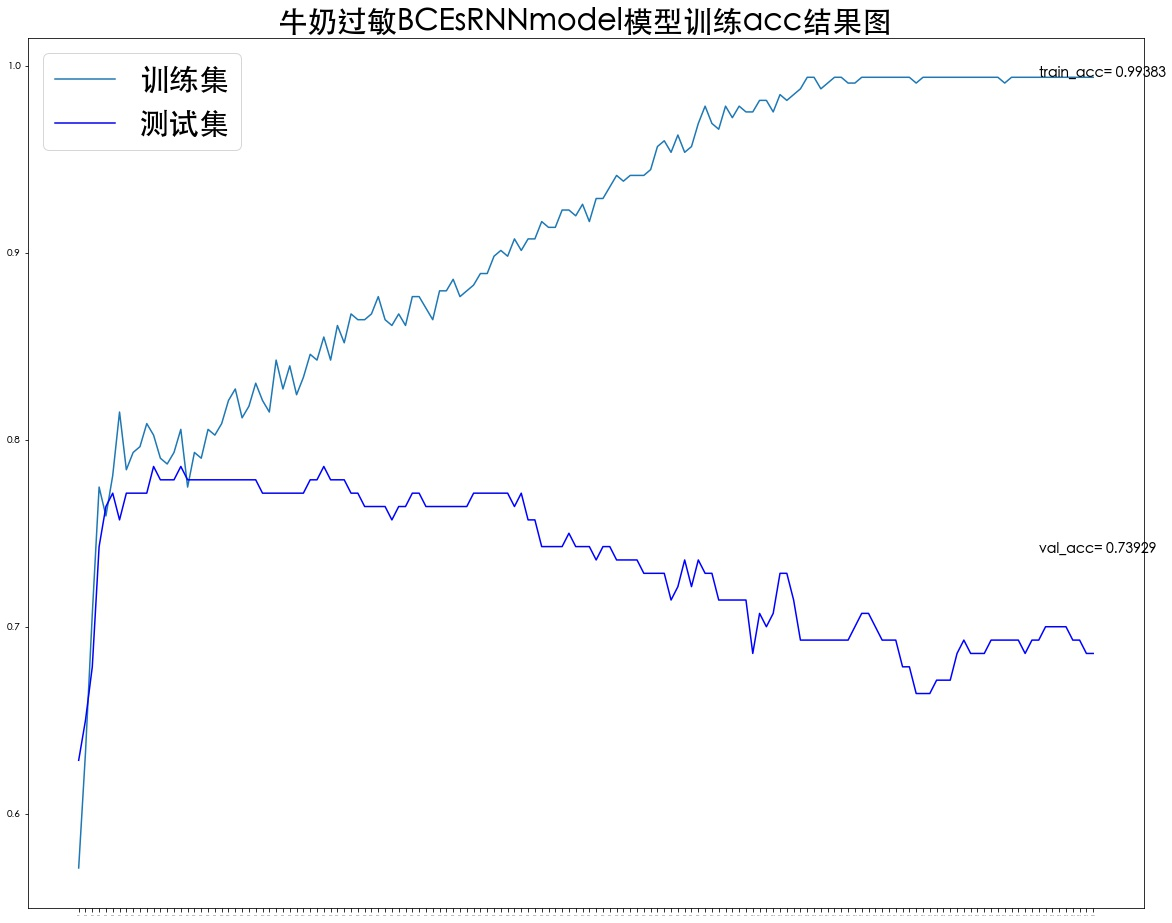

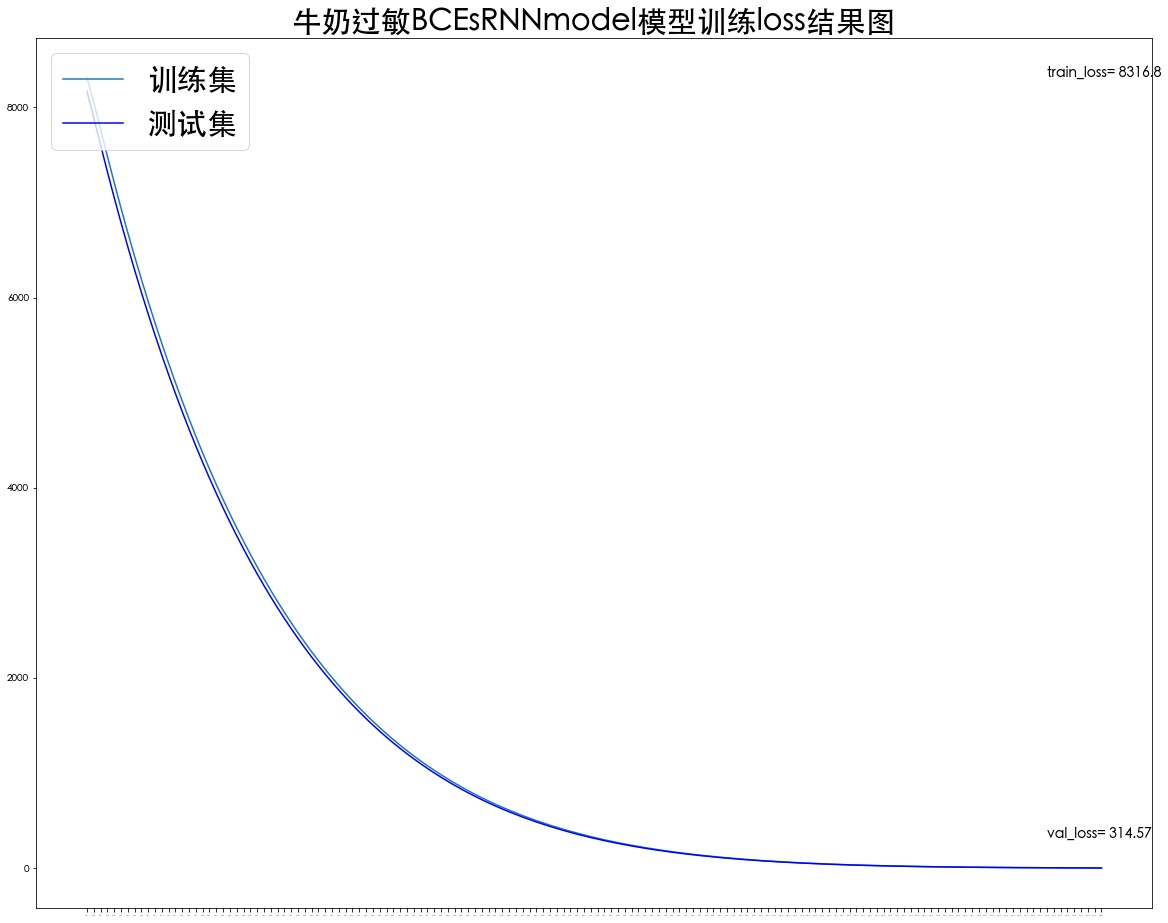

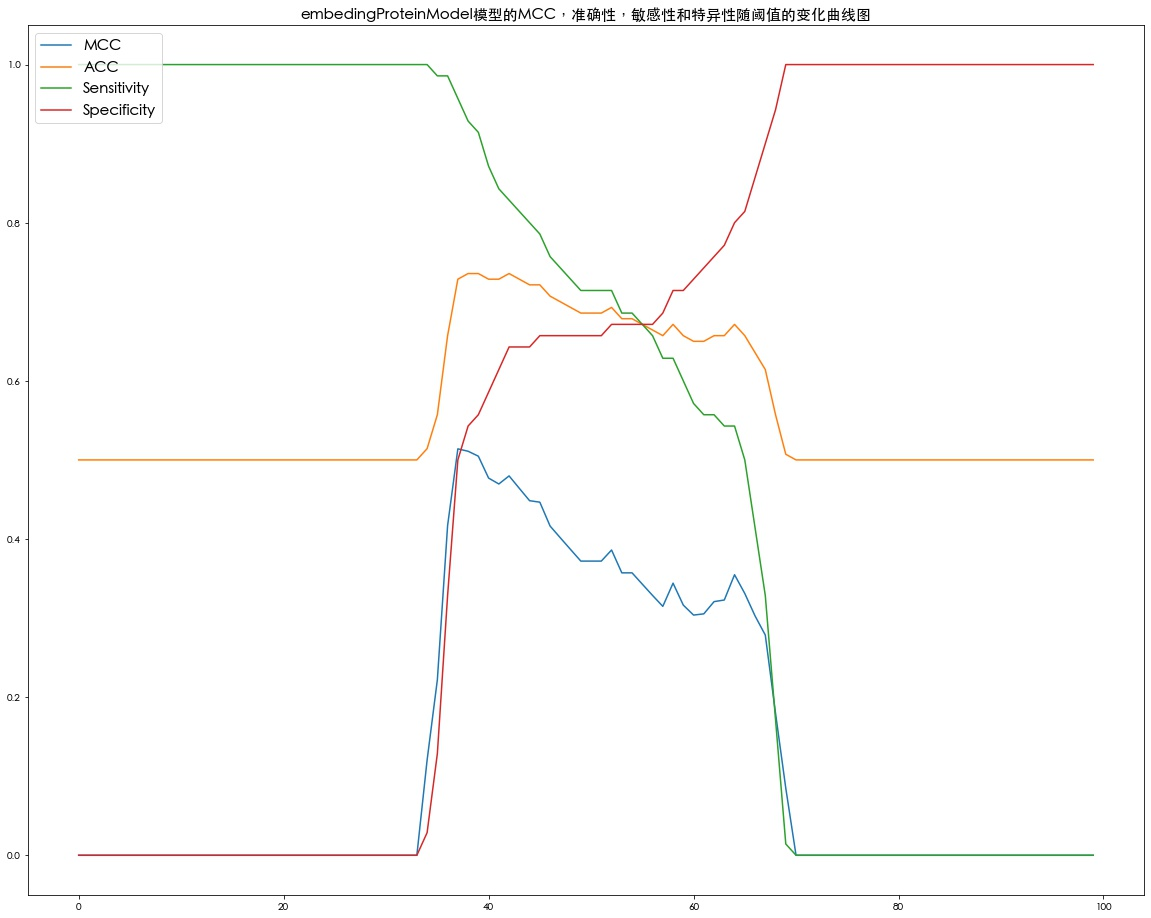

In [500]:
metricsEvaluate(embedingProtein_Ytest,embedingProteinModel.predict(embedingProtein_Xtest),0.5)
drawACCinTwoSet(out,'RNNmodel')
plt.figure()
drawlossinTwoSet(out,'RNNmodel')

y_true =embedingProtein_Ytest
y_pred = embedingProteinModel.predict(embedingProtein_Xtest)
modelName='embedingProteinModel'
#def drawMetrics(y_true,y_pred,modelName = 'unknown'):
out = []
for threshold in [i/100 for i in range(100)]:
    index= metricsIndex(y_true,y_pred,threshold)
    out.append(index)
out = np.array(out)
modelMetrics = pd.DataFrame(out,columns=['MCC','ACC','Sensitivity','Specificity'])
modelMetrics.plot()
plt.legend(loc='upper left',fontsize=15)
plt.title(modelName+'模型的MCC，准确性，敏感性和特异性随阈值的变化曲线图',fontsize=15)
#plt.savefig(modelName+'模型的MCC，准确性，敏感性和特异性随阈值的变化曲线图'+'.jpg',dpi=500)





#### 模型一
```
lr = 0.00025
embedingProteinModel = tf.keras.Sequential()
embedingProteinModel.add(tf.keras.layers.Convolution1D(64,6,strides=1,padding='same',activation='relu'))
#embedingProteinModel.add(tf.keras.layers.MaxPool1D(2))
#embedingProteinModel.add(tf.keras.layers.Flatten())
embedingProteinModel.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)))
#embedingProteinModel.add(tf.keras.layers.Dense(64,activation='relu'))
embedingProteinModel.add(tf.keras.layers.Dense(64,kernel_regularizer= regularizers.l2(100),activation='relu'))
embedingProteinModel.add(tf.keras.layers.Dropout(0.2))
embedingProteinModel.add(tf.keras.layers.Dense(1,activation='sigmoid'))
embedingProteinModel.compile(optimizer=tf.keras.optimizers.Adam(lr),
                            loss = tf.keras.losses.binary_crossentropy,
                            metrics=['acc','AUC'])
```

In [529]:
def embedingModel(lr):
    embedingProteinModel = tf.keras.Sequential()
    embedingProteinModel.add(tf.keras.layers.Convolution1D(64,6,strides=1,padding='same',activation='relu'))
    #embedingProteinModel.add(tf.keras.layers.MaxPool1D(2))
    #embedingProteinModel.add(tf.keras.layers.Flatten())
    embedingProteinModel.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)))
    #embedingProteinModel.add(tf.keras.layers.Dense(64,activation='relu'))
    embedingProteinModel.add(tf.keras.layers.Dense(64,kernel_regularizer= regularizers.l2(100),activation='relu'))
    embedingProteinModel.add(tf.keras.layers.Dropout(0.2))
    embedingProteinModel.add(tf.keras.layers.Dense(1,activation='sigmoid'))
    embedingProteinModel.compile(optimizer=tf.keras.optimizers.Adam(lr),
                                loss = tf.keras.losses.binary_crossentropy,
                                metrics=['acc','AUC'])
    return embedingProteinModel



lr = 0.00025
out = embedingModel(lr).fit(embedingProteintrainDataset,epochs=150,validation_data=embedingProteintestDataset)



Epoch 1/50
4/4 [==============================] - 3s 190ms/step - loss: 6490.9356 - acc: 0.5051 - auc: 0.5149 - val_loss: 6348.6353 - val_acc: 0.5759 - val_auc: 0.5796
Epoch 2/50
4/4 [==============================] - 0s 65ms/step - loss: 6313.9450 - acc: 0.5838 - auc: 0.5892 - val_loss: 6174.5010 - val_acc: 0.5997 - val_auc: 0.6283
Epoch 3/50
4/4 [==============================] - 0s 61ms/step - loss: 6140.5175 - acc: 0.6159 - auc: 0.6396 - val_loss: 6004.0137 - val_acc: 0.6276 - val_auc: 0.6483
Epoch 4/50
4/4 [==============================] - 0s 74ms/step - loss: 5970.7648 - acc: 0.6313 - auc: 0.6699 - val_loss: 5837.2876 - val_acc: 0.6467 - val_auc: 0.6640
Epoch 5/50
4/4 [==============================] - 0s 65ms/step - loss: 5804.7915 - acc: 0.6522 - auc: 0.6896 - val_loss: 5674.3975 - val_acc: 0.6471 - val_auc: 0.6783
Epoch 6/50
4/4 [==============================] - 0s 66ms/step - loss: 5642.6675 - acc: 0.6623 - auc: 0.7032 - val_loss: 5515.3984 - val_acc: 0.6504 - val_auc: 0.68

Epoch 50/50
4/4 [==============================] - 0s 65ms/step - loss: 1499.4457 - acc: 0.7520 - auc: 0.8260 - val_loss: 1461.3201 - val_acc: 0.6733 - val_auc: 0.7095


模型的ACC为:0.43,
模型的敏感性为:0.73,
特异性为:0.17,
MCC系数为:-0.11


/Users/xutingfeng/opt/anaconda3/envs/Bio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Text(0.5, 1.0, 'embedingProteinModel模型的MCC，准确性，敏感性和特异性随阈值的变化曲线图')

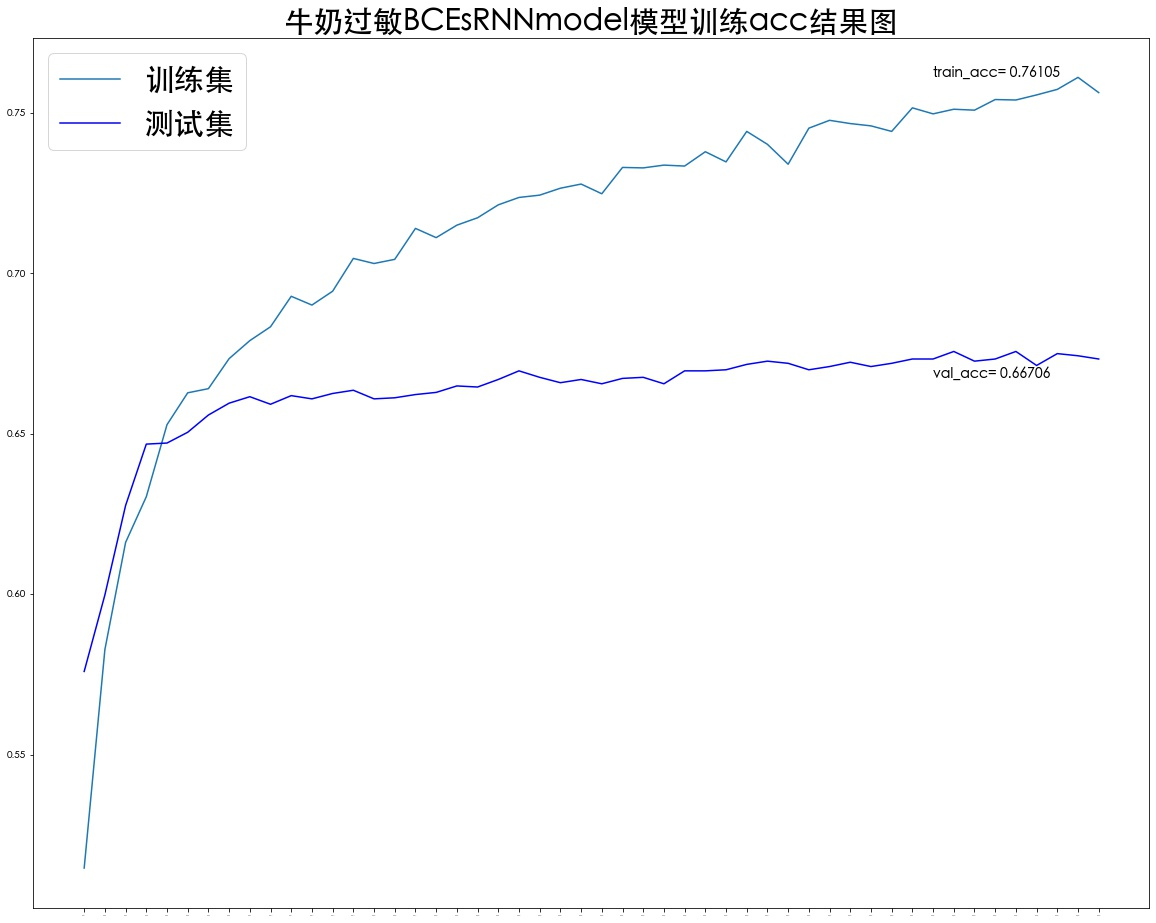

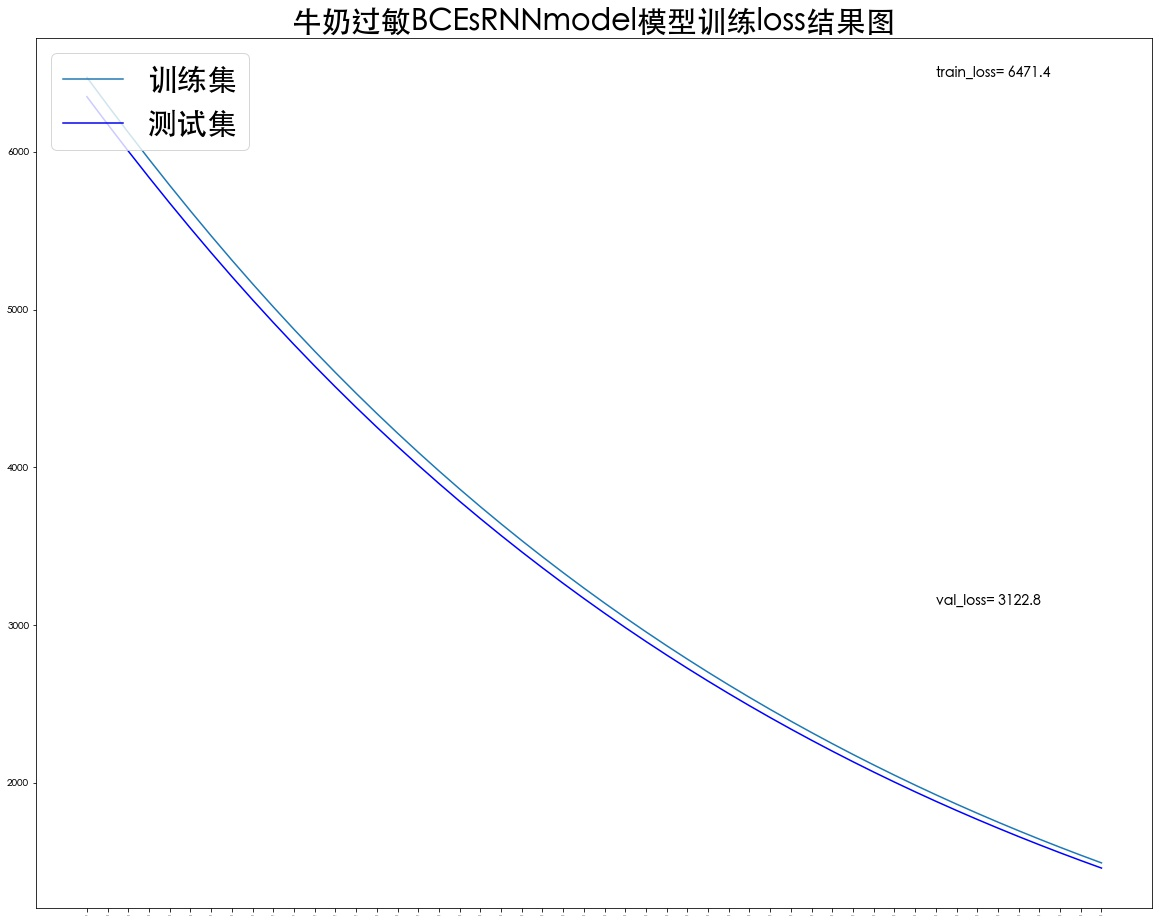

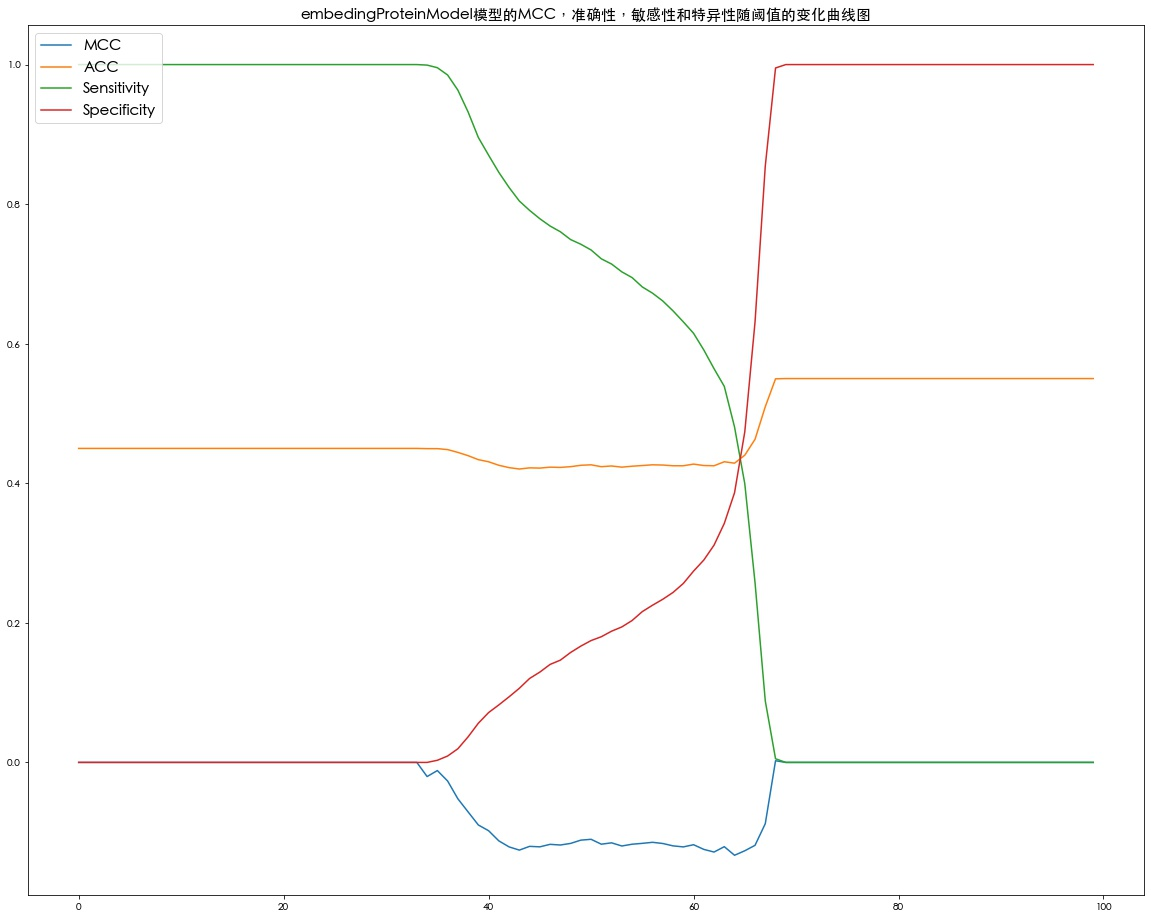

In [530]:
metricsEvaluate(embedingProtein_Ytest,embedingProteinModel.predict(embedingProtein_Xtest),0.5)
drawACCinTwoSet(out,'RNNmodel')
plt.figure()
drawlossinTwoSet(out,'RNNmodel')

y_true =embedingProtein_Ytest
y_pred = embedingProteinModel.predict(embedingProtein_Xtest)
modelName='embedingProteinModel'
#def drawMetrics(y_true,y_pred,modelName = 'unknown'):
out = []
for threshold in [i/100 for i in range(100)]:
    index= metricsIndex(y_true,y_pred,threshold)
    out.append(index)
out = np.array(out)
modelMetrics = pd.DataFrame(out,columns=['MCC','ACC','Sensitivity','Specificity'])
modelMetrics.plot()
plt.legend(loc='upper left',fontsize=15)
plt.title(modelName+'模型的MCC，准确性，敏感性和特异性随阈值的变化曲线图',fontsize=15)
#plt.savefig(modelName+'模型的MCC，准确性，敏感性和特异性随阈值的变化曲线图'+'.jpg',dpi=500)




In [516]:
# #IBCE_EL读入分割好的数据集
# filename = 'tfsDataSet/IBCE_ELData/'


# IBCE_ELAAC_Xtrain,IBCE_ELAAC_Ytrain,IBCE_ELAAC_Xtest,IBCE_ELAAC_Ytest = np.load(filename+'AAC_Xtrain.npy'),np.load(filename+'AAC_Ytrain.npy'),np.load(filename+'AAC_Xtest.npy'),np.load(filename+'AAC_Ytest.npy')
# IBCE_ELDPC_Xtrain,IBCE_ELDPC_Ytrain,IBCE_ELDPC_Xtest,IBCE_ELDPC_Ytest = np.load(filename+'DPC_Xtrain.npy'),np.load(filename+'DPC_Ytrain.npy'),np.load(filename+'DPC_Xtest.npy'),np.load(filename+'DPC_Ytest.npy')
# IBCE_ELCTD_Xtrain,IBCE_ELCTD_Ytrain,IBCE_ELCTD_Xtest,IBCE_ELCTD_Ytest = np.load(filename+'CTD_Xtrain.npy'),np.load(filename+'CTD_Ytrain.npy'),np.load(filename+'CTD_Xtest.npy'),np.load(filename+'CTD_Ytest.npy')
# IBCE_ELAAI_Xtrain,IBCE_ELAAI_Ytrain,IBCE_ELAAI_Xtest,IBCE_ELAAI_Ytest = np.load(filename+'AAI_Xtrain.npy'),np.load(filename+'AAI_Ytrain.npy'),np.load(filename+'AAI_Xtest.npy'),np.load(filename+'AAI_Ytest.npy')
# IBCE_ELRNN_Xtrain,IBCE_ELRNN_Ytrain,IBCE_ELRNN_Xtest,IBCE_ELRNN_Ytest = np.load(filename+'RNN_Xtrain.npy'),np.load(filename+'RNN_Ytrain.npy'),np.load(filename+'RNN_Xtest.npy'),np.load(filename+'RNN_Ytest.npy')
# IBCE_ELembedingProtein_Xtrain,IBCE_ELembedingProtein_Ytrain,IBCE_ELembedingProtein_Xtest,IBCE_ELembedingProtein_Ytest = np.load(filename+'embedingProtein_Xtrain.npy'),np.load(filename+'embedingProtein_Ytrain.npy'),np.load(filename+'embedingProtein_Xtest.npy'),np.load(filename+'embedingProtein_Ytest.npy')

# #转化为td.Dataset类型
# #训练集数据
# IBCE_ELAACtrainDataset = tf.data.Dataset.from_tensor_slices((IBCE_ELAAC_Xtrain,IBCE_ELAAC_Ytrain)).shuffle(100).batch(1024)
# IBCE_ELDPCtrainDataset = tf.data.Dataset.from_tensor_slices((IBCE_ELDPC_Xtrain,IBCE_ELDPC_Ytrain)).shuffle(100).batch(1024)
# IBCE_ELCTDtrainDataset = tf.data.Dataset.from_tensor_slices((IBCE_ELCTD_Xtrain,IBCE_ELCTD_Ytrain)).shuffle(100).batch(1024)
# IBCE_ELAAItrainDataset = tf.data.Dataset.from_tensor_slices((IBCE_ELAAI_Xtrain,IBCE_ELAAI_Ytrain)).shuffle(100).batch(1024)
# IBCE_ELRNNtrainDataset = tf.data.Dataset.from_tensor_slices((IBCE_ELRNN_Xtrain,IBCE_ELRNN_Ytrain)).shuffle(100).batch(1024)
# IBCE_ELembedingProteintrainDataset = tf.data.Dataset.from_tensor_slices((IBCE_ELembedingProtein_Xtrain,IBCE_ELembedingProtein_Ytrain)).shuffle(100).batch(1024)




# #测试集数据
# IBCE_ELAACtestDataset = tf.data.Dataset.from_tensor_slices((IBCE_ELAAC_Xtest,IBCE_ELAAC_Ytest)).shuffle(100).batch(1024)
# IBCE_ELDPCtestDataset = tf.data.Dataset.from_tensor_slices((IBCE_ELDPC_Xtest,IBCE_ELDPC_Ytest)).shuffle(100).batch(1024)
# IBCE_ELCTDtestDataset = tf.data.Dataset.from_tensor_slices((IBCE_ELCTD_Xtest,IBCE_ELCTD_Ytest)).shuffle(100).batch(1024)
# IBCE_ELAAItestDataset = tf.data.Dataset.from_tensor_slices((IBCE_ELAAI_Xtest,IBCE_ELAAI_Ytest)).shuffle(100).batch(1024)
# IBCE_ELRNNtestDataset = tf.data.Dataset.from_tensor_slices((IBCE_ELRNN_Xtest,IBCE_ELRNN_Ytest)).shuffle(100).batch(1024)
# IBCE_ELembedingProteintestDataset = tf.data.Dataset.from_tensor_slices((IBCE_ELembedingProtein_Xtest,IBCE_ELembedingProtein_Ytest)).shuffle(100).batch(1024)



In [521]:
# embedingProteinModel.evaluate(IBCE_ELembedingProteintrainDataset)

4/4 [==============================] - 0s 32ms/step - loss: 2.9055 - acc: 0.4232 - auc: 0.4333


[2.9055330753326416, 0.4232042729854584, 0.43334269523620605]

## 基于AAC的特征的模型构建

In [ ]:
AACModel = tf.keras.Sequential()
AACModel.add